In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## 학습 이미지 불러오기

In [ ]:
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L') # grayscale
    pil_im=pil_im.resize((105,105))
    return pil_im

## 이미지 증폭 함수

1. 노이즈
2. 블러
3. affine 변환
4. 그라데이션

In [ ]:
# Adding Noise to image
def noise_image(pil_im):
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    noise_img = noise_img.resize((105,105))
    return noise_img

In [ ]:
# Adding Blur to image 
def blur_image(pil_im):
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    blur_img = blur_img.resize((105,105))
    return blur_img

In [ ]:
# Perpective Rotation
def affine_rotation(img):
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    affine_img = affine_img.resize((105,105))
    return affine_img

In [ ]:
# Shading
def gradient_fill(image):
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

## 데이터셋 준비

In [ ]:
data_path = "/content/drive/MyDrive/GPR/211126_1/font_image"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
# font labeling
dir_tuple = tuple(os.listdir(data_path))

def conv_label(label):
  if label in dir_tuple :
    font_no = dir_tuple.index(label)
  return font_no

In [ ]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    data.append(org_img)
    labels.append(label)
    
    augument=["noise","blur","affine","gradient"]
    for l in range(0,len(augument)):
    
        a=itertools.combinations(augument, l+1)

        for i in list(a): 
            combinations=list(i)
            temp_img = pil_img
            for j in combinations:
            
                if j == 'noise':
                    # Adding Noise image
                    temp_img = noise_image(temp_img)
                    
                elif j == 'blur':
                    # Adding Blur image
                    temp_img = blur_image(temp_img)
                    
                elif j == 'affine':
                    open_cv_affine = np.array(pil_img)
                    # Adding affine rotation image
                    temp_img = affine_rotation(open_cv_affine)

                elif j == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    # Adding gradient image
                    temp_img = gradient_fill(open_cv_gradient)
  
            temp_img = img_to_array(temp_img)
            data.append(temp_img)
            labels.append(label)

In [ ]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,	labels, test_size=0.25, random_state=42)

Success


In [ ]:
num_classes = len(dir_tuple)
num_classes

30

In [ ]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes)
testY = to_categorical(testY, num_classes)

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [ ]:
K.set_image_dim_ordering('tf')

In [ ]:
 def create_model():
  model=Sequential()

  # Cu Layers 
  model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  #Cs Layers
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))
  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2383,activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
 
  return model

In [ ]:
batch_size = 64
epochs = 20
model= create_model()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="find_font.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [ ]:
hist = model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 25776 samples, validate on 8592 samples
Epoch 1/20
25776/25776 [==============================] - 90s 3ms/step - loss: 0.0322 - acc: 0.0455 - val_loss: 0.0321 - val_acc: 0.0945

Epoch 00001: val_loss improved from inf to 0.03207, saving model to top_model_1126_1.h5
Epoch 2/20
25776/25776 [==============================] - 79s 3ms/step - loss: 0.0319 - acc: 0.0807 - val_loss: 0.0312 - val_acc: 0.1266

Epoch 00002: val_loss improved from 0.03207 to 0.03121, saving model to top_model_1126_1.h5
Epoch 3/20
25776/25776 [==============================] - 79s 3ms/step - loss: 0.0304 - acc: 0.1437 - val_loss: 0.0280 - val_acc: 0.2172

Epoch 00003: val_loss improved from 0.03121 to 0.02796, saving model to top_model_1126_1.h5
Epoch 4/20
25776/25776 [==============================] - 79s 3ms/step - loss: 0.0267 - acc: 0.2701 - val_loss: 0.0240 - val_acc: 0.3386

Epoch 00004: val_loss improved from 0.02796 to 0.02403, saving model to top_mod

In [ ]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.001080880676218431
Test accuracy: 0.9775372439478585


Test loss: 0.001080880676218431
Test accuracy: 0.9775372439478585


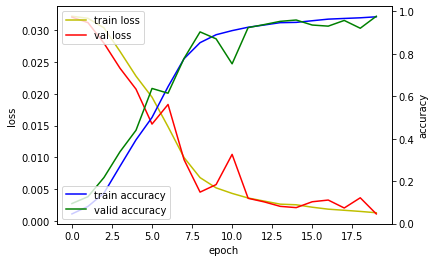

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(hist.history['acc'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_acc'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
img_path="/content/drive/MyDrive/GPR/211126_1/test_image/Fine Serif.png"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im=pil_im.resize((105,105))
org_img = img_to_array(pil_im)

In [ ]:
def rev_conv_label(label):
  if label <= len(dir_tuple):
    no_font = dir_tuple[label]
  return no_font

In [ ]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [ ]:
y = model.predict_classes(data)

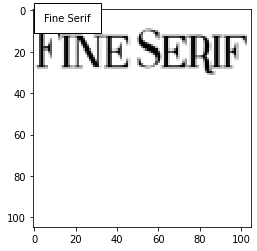

In [ ]:
label = rev_conv_label(int(y[0]))
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()

In [ ]:
test_font = model.predict(data)
font_idx  = np.argmax(test_font)

font_score=[]
for i in range(testY.shape[-1]):
    font_score.append((np.round(test_font[0][i], 3), rev_conv_label(i)))
font_score.sort(reverse=True)

for i in range(5):
    print(f"{font_score[i][1]} : {round(font_score[i][0] * 100, 4)} %")

Fine Serif : 97.1 %
Josefin Slab-Regular : 2.6 %
Spinnaker-Regular : 0.1 %
Alycidon-Condensed : 0.1 %
Slabby Prices Slab-Regular : 0.0 %
